FE 과제

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#사용될 라이브러리들을 import합니다.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#경고 문구 무시
import warnings
warnings.filterwarnings('ignore')

#matplotlib 스타일 정의
plt.style.use('fivethirtyeight')

#bureau.csv 파일을 import합니다.
titanic = pd.read_csv('/content/gdrive/MyDrive/교육세션/0118 FE/train.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


1. imputing


null값의 비중

In [3]:
titanic.isna().sum()/len(titanic)*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

null의 비중이 77%인 Cabin은 drop한다.
age는 따로 피쳐 만듦

In [4]:
titanic.drop(columns=['Cabin'], inplace=True)
age_null = 'Age_NULL'
titanic[age_null] = 0
for i in range(len(titanic)):
    if np.isnan(titanic.loc[i,'Age'])==True:
      titanic.loc[i,age_null] = 1

In [5]:
titanic['Age'].dtype
titanic['Age_NULL'].sum()

177

In [6]:
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_NULL
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,0


In [7]:
titanic['Age'] = titanic['Age'].fillna(titanic['Age'].median())
from scipy. stats import mode
mode(titanic['Embarked']) # "S"가 최빈값
titanic['Embarked'] = titanic['Embarked'].fillna("S")

2. Encoding


In [8]:
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
Age_NULL         int64
dtype: object

In [9]:
columns = ['Name','Sex','SibSp','Ticket','Embarked']
for c in columns:
    print(c,titanic[c].nunique())

Name 891
Sex 2
SibSp 7
Ticket 681
Embarked 3


In [10]:
print(titanic['Sex'].unique())
print(titanic['SibSp'].unique())
print(titanic['Embarked'].unique())


['male' 'female']
[1 0 3 4 2 5 8]
['S' 'C' 'Q']


sex, embarked는 원핫 인코딩 처리하고 Sipsp는 숫자로 바꿀 것이다.
name과 ticket데이터는 drop하였다. 

In [11]:
titanic.drop(columns=['Name','Ticket'], inplace=True)
titanic = pd.get_dummies(titanic,columns=['Sex']) 
titanic = pd.get_dummies(titanic,columns=['Embarked']) 
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Age_NULL', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S'],
      dtype='object')

In [13]:
for i in range(len(titanic)):
    titanic.loc[i,'SibSp'] = int(titanic.loc[i,'SibSp'])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_NULL,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,0,0,1,0,0,1
1,2,1,1,38.0,1,0,71.2833,0,1,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,0,1,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,1,0,0,0,1
4,5,0,3,35.0,0,0,8.0500,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000,0,0,1,0,0,1
887,888,1,1,19.0,0,0,30.0000,0,1,0,0,0,1
888,889,0,3,28.0,1,2,23.4500,1,1,0,0,0,1
889,890,1,1,26.0,0,0,30.0000,0,0,1,1,0,0


3. outlier removing

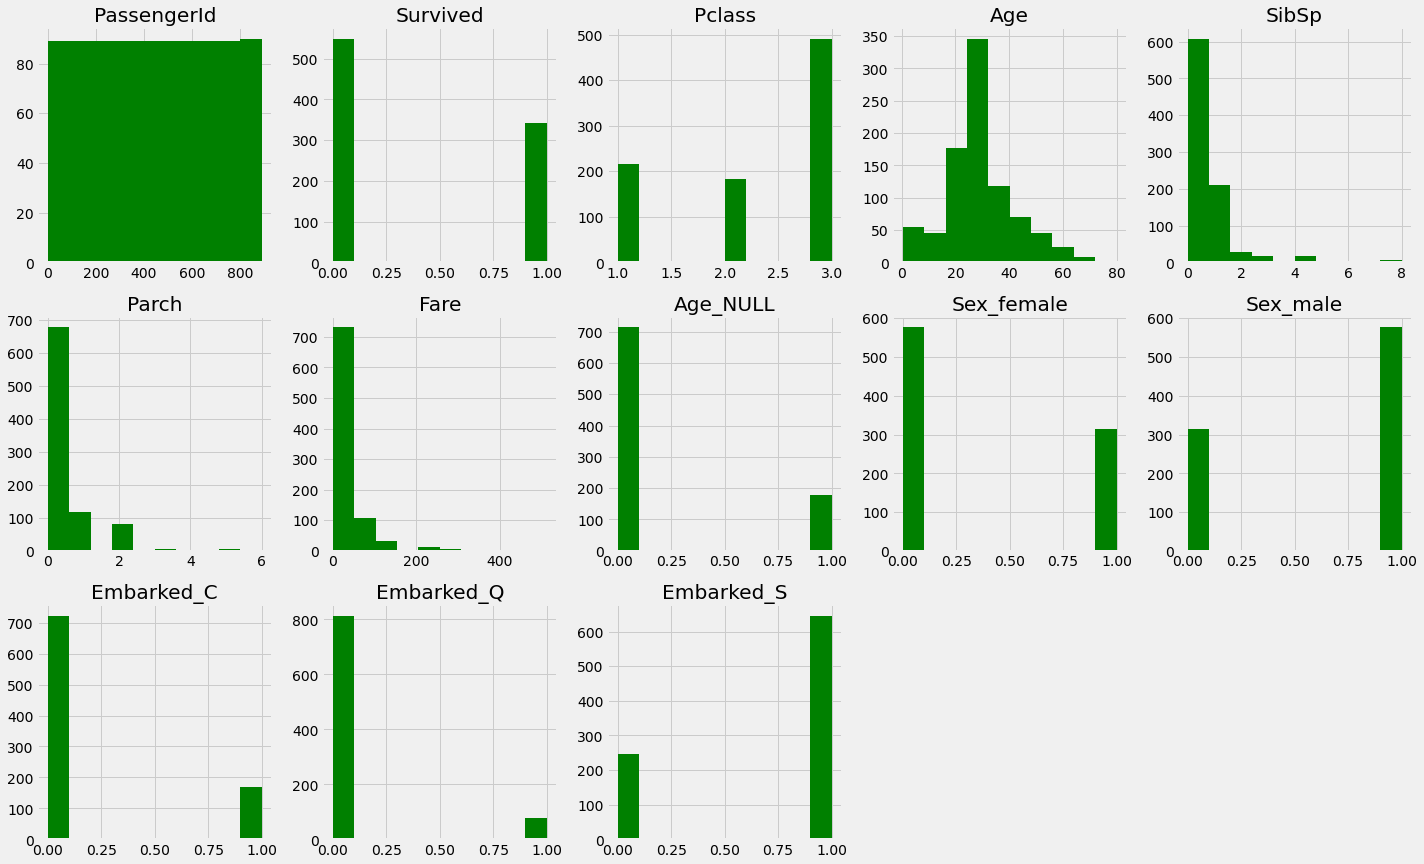

In [17]:
plt.figure(figsize=(20,20))
for i, col in enumerate(titanic.columns.to_list()):
    plt.subplot(5, 5, i + 1)
    plt.hist(titanic[col], label=col,color='green')
    plt.title(col)
    plt.tight_layout()

age, fare를 검사해보자

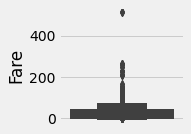

In [30]:
plt.figure(figsize=(2,2))
sns.boxplot(data=titanic, y='Age')
sns.boxplot(data=titanic, y='Fare')

이상치가 있으니 제거하자

In [28]:
def outliers_iqr(data):
  q1, q3=np.percentile(data, [25, 75])
  iqr = q3-q1
  lower_bound=q1-(iqr*1.5)
  upper_bound=q3+(iqr*1.5)
  return np.where((data>upper_bound)|(data<lower_bound))

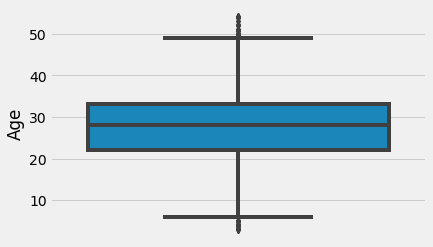

In [50]:
age_outlier_index = outliers_iqr(titanic['Age'])
fare_outlier_index = outliers_iqr(titanic['Fare'])
outlier_index=np.concatenate((age_outlier_index, fare_outlier_index),axis=None)
not_outlier_index=[]
for i in titanic.index:
  if i not in outlier_index:
    not_outlier_index.append(i)
outlier_index
titanic_clean=titanic.loc[not_outlier_index]
titanic_clean
sns.boxplot(data=titanic_clean, y='Age') # 이상치가 없어졌다

4. correlation removing

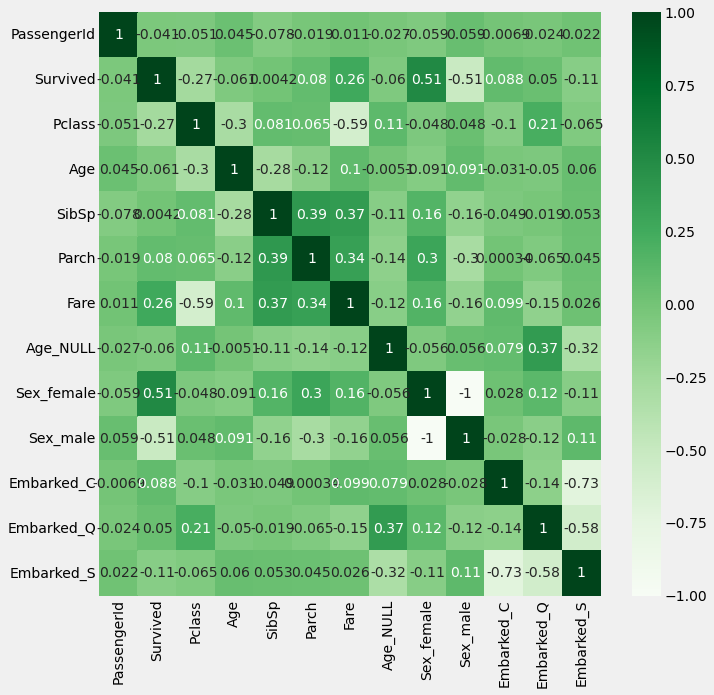

In [53]:
plt.figure(figsize=(10,10))
sns.heatmap(titanic_clean.corr(), annot=True, cmap='Greens')

지나치게 높은 값은 없다!

In [54]:
titanic_clean

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_NULL,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,0,0,1,0,0,1
2,3,1,3,26.0,0,0,7.9250,0,1,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,1,0,0,0,1
4,5,0,3,35.0,0,0,8.0500,0,0,1,0,0,1
5,6,0,3,28.0,0,0,8.4583,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000,0,0,1,0,0,1
887,888,1,1,19.0,0,0,30.0000,0,1,0,0,0,1
888,889,0,3,28.0,1,2,23.4500,1,1,0,0,0,1
889,890,1,1,26.0,0,0,30.0000,0,0,1,1,0,0
